In [13]:
#source 3.8.10 (not 3.11)
import numpy as np
import matplotlib.pyplot as plt

!pip3 install pyyaml
import yaml
from yaml.loader import SafeLoader

In [14]:
# Params

Fz0 = 56.699*9.81 # 125lbs
R = 0.2
ftw = 1.22
rtw = 1.22
wb = 1.59
wd = 0.5949 # more in the back
ad = 0.5
air_dens = 1.225
ClA = 5.47
CdA = 1.8
m = 185 
Iz = 100 # ???
Iw = 0.06 # ???
g = 9.81
h = 0.3 # ???
bb = 0.5 # Break bias

pcx1 = 1.49897197
pdx1 = 2.26070458
pdx2 = -0.0819377573
pdx3 = -4.30583270
pex1 = -0.394373761
pex2 = -3.25004019
pex3 = -1.35389672
pex4 = 0.000612624634
pkx1 = 39.5605635
pkx2 = 35.2985738
pkx3 = -1.68401638

pcy1 = 2.10629967
pdy1 = 2.40157711
pdy2 = -0.27302573
pdy3 = 3.05179651
pey1 = 0.34211991
pey2 = -0.46384504
pey3 = 0.06350494
pey4 = 7.72098907
pky1 = -28.78400172
pky2 = 1.21529087
pky3 = 0.59053696
phy3 = -0.15013063
pvy3 = -0.67569663
pvy4 = 0.99989196

qbz1 = 12.2921809
qbz2 = -4.18453295
qbz3 = -10.8905133
qbz4 = 0.0376620441
qbz5 = -0.620973261
qbz9 = 0
qbz10 = 1.53964053
qcz1 = 1.22023371
qdz1 = 0.268208451
qdz2 = -0.0139664562
qdz3 = -0.886086130
qdz4 = 0.463608221
qdz6 = 0.0119804919
qdz7 = -0.0421554345
qdz8 = 2.53743081
qdz9 = 0.807777246
qez1 = 0.0261762894
qez2 = 0.619970018
qez3 = -0.185440736
qez4 = -1.41367053
qez5 = -0.849648469
qhz3 = 0.162951539
qhz4 = 0.241080034

In [15]:
class state_obj:
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.Ux = 0
        self.Uy = 0
        self.yaw_rate = 0
        self.w_rl = 0
        self.w_rr = 0
        self.w_fl = 0
        self.w_fr = 0
        self.ax = 0
        self.ay = 0
        self.steer_angle = 0
        
    def __add__(self, other):
        self.x = self.x + other.x
        self.y = self.y + other.y
        self.yaw = self.yaw + other.yaw
        self.Ux = self.Ux + other.Ux
        self.Uy = self.Uy + other.Uy
        self.yaw_rate = self.yaw_rate + other.yaw_rate
        self.w_rl = self.w_rl + other.w_rl
        self.w_rr = self.w_rr + other.w_rr
        self.w_fl = self.w_fl + other.w_fl
        self.w_fr = self.w_fr + other.w_fr
        self.ax = self.ax + other.ax
        self.ay = self.ay + other.ay
        self.steer_angle = self.steer_angle + other.steer_angle
        return self
        
    def __mul__(self, other):
        if isinstance(other, state_obj):
            self.x = self.x * other.x
            self.y = self.y * other.y
            self.yaw = self.yaw * other.yaw
            self.Ux = self.Ux * other.Ux
            self.Uy = self.Uy * other.Uy
            self.yaw_rate = self.yaw_rate * other.yaw_rate
            self.w_rl = self.w_rl * other.w_rl
            self.w_rr = self.w_rr * other.w_rr
            self.w_fl = self.w_fl * other.w_fl
            self.w_fr = self.w_fr * other.w_fr
            self.ax = self.ax * other.ax
            self.ay = self.ay * other.ay
            # self.steer_angle = self.steer_angle * other.steer_angle
        elif isinstance(other, float) or isinstance(other, int):
            self.x = self.x * other
            self.y = self.y * other
            self.yaw = self.yaw * other
            self.Ux = self.Ux * other
            self.Uy = self.Uy * other
            self.yaw_rate = self.yaw_rate * other
            self.w_rl = self.w_rl * other
            self.w_rr = self.w_rr * other
            self.w_fl = self.w_fl * other
            self.w_fr = self.w_fr * other
            self.ax = self.ax * other
            self.ay = self.ay * other
            # self.steer_angle = self.steer_angle * other
        return self

        
class input_obj:
    def __init__(self):
        self.Tg = 0
        self.Tb = 0
        self.steer_angle = 0
        
        
class quantity_per_tire:
    def __init__(self):
        self.rl = 0
        self.rr = 0
        self.fl = 0
        self.fr = 0

In [16]:
# Note: wd = weight distribution, wb = wheelbase, rtw = rear track width, ftw = front track width
def compute_slip_ratios(state,inputs):
    sr = quantity_per_tire()
    sr.rl = (state.w_rl*R - (state.Ux + (rtw/2)*state.yaw_rate))/np.sqrt(1 + (state.Ux + (rtw/2)*state.yaw_rate)**2)
    sr.rr = (state.w_rr*R - (state.Ux - (rtw/2)*state.yaw_rate))/np.sqrt(1 + (state.Ux - (rtw/2)*state.yaw_rate)**2)
    sr.fl = (state.w_fl*R - (np.cos(inputs.steer_angle)*(state.Ux + state.yaw_rate*ftw/2) + np.sin(inputs.steer_angle)*(state.Uy + state.yaw_rate*wd*wb)))/np.sqrt(1 + (np.cos(inputs.steer_angle)*(state.Ux + state.yaw_rate*ftw/2) + np.sin(inputs.steer_angle)*(state.Uy + state.yaw_rate*wd*wb))**2)
    sr.fr = (state.w_fr*R - (np.cos(inputs.steer_angle)*(state.Ux - state.yaw_rate*ftw/2) + np.sin(inputs.steer_angle)*(state.Uy + state.yaw_rate*wd*wb)))/np.sqrt(1 + (np.cos(inputs.steer_angle)*(state.Ux - state.yaw_rate*ftw/2) + np.sin(inputs.steer_angle)*(state.Uy + state.yaw_rate*wd*wb))**2)      
    return sr


def compute_slip_angles(state,inputs):
    sa = quantity_per_tire()
    sa.rl = np.arctan((state.Uy - state.yaw_rate*(1-wd)*wb)/np.sqrt(1 + (state.Ux + state.yaw_rate*rtw/2)**2))
    sa.rr = np.arctan((state.Uy - state.yaw_rate*(1-wd)*wb)/np.sqrt(1 + (state.Ux - state.yaw_rate*rtw/2)**2))
    sa.fl = np.arctan((state.Uy + state.yaw_rate*wd*wb)/np.sqrt(1 + (state.Ux + state.yaw_rate*ftw/2)**2)) - inputs.steer_angle
    sa.fr = np.arctan((state.Uy + state.yaw_rate*wd*wb)/np.sqrt(1 + (state.Ux - state.yaw_rate*ftw/2)**2)) - inputs.steer_angle
    return sa

In [17]:
# Note: wd = weight distribution, wb = wheelbase, rtw = rear track width, ftw = front track width, h = COG height, ad = aero distribution, air_dens = air density, ClA = downforce coefficient
def compute_Fz(state,inputs):
    Fz = quantity_per_tire()
    Fz.rl = (1/2)*m*g*wd + (1/2)*m*h*state.ax/wb + (1/2)*m*h*state.ay/rtw + (1/2)*ad*(1/2)*air_dens*ClA*state.Ux**2
    Fz.rr = (1/2)*m*g*wd + (1/2)*m*h*state.ax/wb - (1/2)*m*h*state.ay/rtw + (1/2)*ad*(1/2)*air_dens*ClA*state.Ux**2
    Fz.fl = (1/2)*m*g*(1-wd) - (1/2)*m*h*state.ax/wb + (1/2)*m*h*state.ay/ftw + (1/2)*(1-ad)*(1/2)*air_dens*ClA*state.Ux**2
    Fz.fr = (1/2)*m*g*(1-wd) - (1/2)*m*h*state.ax/wb - (1/2)*m*h*state.ay/ftw + (1/2)*(1-ad)*(1/2)*air_dens*ClA*state.Ux**2
    return Fz

def compute_dfz(state,inputs):
    dfz = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz.rl = (Fz.rl - Fz0)/Fz0
    dfz.rr = (Fz.rr - Fz0)/Fz0
    dfz.fl = (Fz.fl - Fz0)/Fz0
    dfz.fr = (Fz.fr - Fz0)/Fz0
    return dfz

In [18]:
def compute_Bx(state,inputs):
    Bx = quantity_per_tire()
    Dx = compute_Dx(state,inputs)
    Kx = compute_Kx(state,inputs)
    Bx.rl = Kx.rl/(pcx1*Dx.rl)
    Bx.rr = Kx.rr/(pcx1*Dx.rr)
    Bx.fl = Kx.fl/(pcx1*Dx.fl)
    Bx.fr = Kx.fr/(pcx1*Dx.fr)
    return Bx

def compute_By(state,inputs):
    By = quantity_per_tire()
    Dy = compute_Dy(state,inputs)
    Ky = compute_Ky(state,inputs)
    By.rl = Ky.rl/(pcy1*Dy.rl)
    By.rr = Ky.rr/(pcy1*Dy.rr)
    By.fl = Ky.fl/(pcy1*Dy.fl)
    By.fr = Ky.fr/(pcy1*Dy.fr)
    return By

def compute_Bt(state,inputs):
    Bt = quantity_per_tire()
    dfz = compute_dfz(state,inputs)
    Dx = compute_Dx(state,inputs)
    Bt.rl = (qbz1 + qbz2*dfz.rl + qbz3*dfz.rl**2)*(1 + qbz4*camber.rl + qbz5*np.abs(camber.rl))
    Bt.rr = (qbz1 + qbz2*dfz.rr + qbz3*dfz.rr**2)*(1 + qbz4*camber.rr + qbz5*np.abs(camber.rr))
    Bt.fl = (qbz1 + qbz2*dfz.fl + qbz3*dfz.fl**2)*(1 + qbz4*camber.fl + qbz5*np.abs(camber.fl))
    Bt.fr = (qbz1 + qbz2*dfz.fr + qbz3*dfz.fr**2)*(1 + qbz4*camber.fr + qbz5*np.abs(camber.fr))
    return Bt

def compute_Br(state,inputs):
    Br = quantity_per_tire()
    By = compute_Dy(state,inputs)
    Br.rl = qbz9 + qbz10*By.rl*pcy1
    Br.rr = qbz9 + qbz10*By.rr*pcy1
    Br.fl = qbz9 + qbz10*By.fl*pcy1
    Br.fr = qbz9 + qbz10*By.fr*pcy1
    return Br

def compute_Dx(state,inputs):
    Dx = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz = compute_dfz(state,inputs)
    Dx.rl = (pdx1 + pdx2*dfz.rl)*(1 - pdx3*camber.rl**2)*0.66*Fz.rl
    Dx.rr = (pdx1 + pdx2*dfz.rr)*(1 - pdx3*camber.rr**2)*0.66*Fz.rr
    Dx.fl = (pdx1 + pdx2*dfz.fl)*(1 - pdx3*camber.fl**2)*0.66*Fz.fl
    Dx.fr = (pdx1 + pdx2*dfz.fr)*(1 - pdx3*camber.fr**2)*0.66*Fz.fr
    return Dx

def compute_Dy(state,inputs):
    Dy = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz = compute_dfz(state,inputs)
    Dy.rl = (pdy1 + pdy2*dfz.rl)*(1 - pdy3*camber.rl**2)*0.66*Fz.rl
    Dy.rr = (pdy1 + pdy2*dfz.rr)*(1 - pdy3*camber.rr**2)*0.66*Fz.rr
    Dy.fl = (pdy1 + pdy2*dfz.fl)*(1 - pdy3*camber.fl**2)*0.66*Fz.fl
    Dy.fr = (pdy1 + pdy2*dfz.fr)*(1 - pdy3*camber.fr**2)*0.66*Fz.fr
    return Dy

def compute_Dt(state,inputs):
    Dt = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz = compute_dfz(state,inputs)
    Dt.rl = Fz.rl*(qdz1 + qdz2*dfz.rl)*(1 + qdz3*camber.rl + qdz4*camber.rl**2)*(R/Fz0)
    Dt.rr = Fz.rr*(qdz1 + qdz2*dfz.rr)*(1 + qdz3*camber.rr + qdz4*camber.rr**2)*(R/Fz0)
    Dt.fl = Fz.fl*(qdz1 + qdz2*dfz.fl)*(1 + qdz3*camber.fl + qdz4*camber.fl**2)*(R/Fz0)
    Dt.fr = Fz.fr*(qdz1 + qdz2*dfz.fr)*(1 + qdz3*camber.fr + qdz4*camber.fr**2)*(R/Fz0)
    return Dt

def compute_Dr(state,inputs):
    Dr = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz = compute_dfz(state,inputs)
    Dr.rl = Fz.rl*((qdz6 + qdz7*dfz.rl) + (qdz8 + qdz9*dfz.rl)*camber.rl)*R
    Dr.rr = Fz.rr*((qdz6 + qdz7*dfz.rr) + (qdz8 + qdz9*dfz.rr)*camber.rr)*R
    Dr.fl = Fz.fl*((qdz6 + qdz7*dfz.fl) + (qdz8 + qdz9*dfz.fl)*camber.fl)*R
    Dr.fr = Fz.fr*((qdz6 + qdz7*dfz.fr) + (qdz8 + qdz9*dfz.fr)*camber.fr)*R
    return Dr

def compute_Ex(state,inputs):
    Ex = quantity_per_tire()
    sr = compute_slip_ratios(state,inputs)
    dfz = compute_dfz(state,inputs)
    Ex.rl = (pex1 + pex2*dfz.rl + pex3*dfz.rl**2)*(1 - pex4*np.sign(sr.rl))
    Ex.rr = (pex1 + pex2*dfz.rr + pex3*dfz.rr**2)*(1 - pex4*np.sign(sr.rr))
    Ex.fl = (pex1 + pex2*dfz.fl + pex3*dfz.fl**2)*(1 - pex4*np.sign(sr.fl))
    Ex.fr = (pex1 + pex2*dfz.fr + pex3*dfz.fr**2)*(1 - pex4*np.sign(sr.fr))
    return Ex

def compute_Ey(state,inputs):
    Ey = quantity_per_tire()
    say = compute_slip_angles_y(state,inputs)
    dfz = compute_dfz(state,inputs)
    Ey.rl = (pey1 + pey2*dfz.rl)*(1 - (pey3 + pey4*camber.rl)*np.sign(say.rl))
    Ey.rr = (pey1 + pey2*dfz.rr)*(1 - (pey3 + pey4*camber.rr)*np.sign(say.rr))
    Ey.fl = (pey1 + pey2*dfz.fl)*(1 - (pey3 + pey4*camber.fl)*np.sign(say.fl))
    Ey.fr = (pey1 + pey2*dfz.fr)*(1 - (pey3 + pey4*camber.fr)*np.sign(say.fr))
    return Ey

def compute_Et(state,inputs):
    Et = quantity_per_tire()
    sat = compute_slip_angles_t(state,inputs)
    dfz = compute_dfz(state,inputs)
    Bt = compute_Bt(state,inputs)
    Et.rl = min(1, (qez1 + qez2*dfz.rl + qez3*dfz.rl**2)*(1 + (qez4 + qez5*camber.rl)*(2/np.pi)*np.arctan(Bt.rl*qcz1*sat.rl)))
    Et.rr = min(1, (qez1 + qez2*dfz.rr + qez3*dfz.rr**2)*(1 + (qez4 + qez5*camber.rr)*(2/np.pi)*np.arctan(Bt.rr*qcz1*sat.rr)))
    Et.fl = min(1, (qez1 + qez2*dfz.fl + qez3*dfz.fl**2)*(1 + (qez4 + qez5*camber.fl)*(2/np.pi)*np.arctan(Bt.fl*qcz1*sat.fl)))
    Et.fr = min(1, (qez1 + qez2*dfz.fr + qez3*dfz.fr**2)*(1 + (qez4 + qez5*camber.fr)*(2/np.pi)*np.arctan(Bt.fr*qcz1*sat.fr)))
    return Et

def compute_Kx(state,inputs):
    Kx = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz = compute_dfz(state,inputs)
    Kx.rl = Fz.rl*(pkx1 + pkx2*dfz.rl)*np.exp(pkx3*dfz.rl)
    Kx.rr = Fz.rr*(pkx1 + pkx2*dfz.rr)*np.exp(pkx3*dfz.rr)
    Kx.fl = Fz.fl*(pkx1 + pkx2*dfz.fl)*np.exp(pkx3*dfz.fl)
    Kx.fr = Fz.fr*(pkx1 + pkx2*dfz.fr)*np.exp(pkx3*dfz.fr)
    return Kx

def compute_Ky(state,inputs):
    Ky = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    Ky.rl = pky1*Fz0*np.sin(2*np.arctan(Fz.rl/(pky2*Fz0)))*(1 - pky3*np.abs(camber.rl))
    Ky.rr = pky1*Fz0*np.sin(2*np.arctan(Fz.rr/(pky2*Fz0)))*(1 - pky3*np.abs(camber.rr))
    Ky.fl = pky1*Fz0*np.sin(2*np.arctan(Fz.fl/(pky2*Fz0)))*(1 - pky3*np.abs(camber.fl))
    Ky.fr = pky1*Fz0*np.sin(2*np.arctan(Fz.fr/(pky2*Fz0)))*(1 - pky3*np.abs(camber.fr))
    return Ky

def compute_slip_angles_y(state,inputs):
    say = quantity_per_tire()
    sa = compute_slip_angles(state,inputs)
    say.rl = sa.rl + phy3*camber.rl
    say.rr = sa.rr + phy3*camber.rr
    say.fl = sa.fl + phy3*camber.fl
    say.fr = sa.fr + phy3*camber.fr
    return say

def compute_slip_angles_t(state,inputs):
    sat = quantity_per_tire()
    dfz = compute_dfz(state,inputs)
    sa = compute_slip_angles(state,inputs)
    sat.rl = sa.rl + (qhz3 + qhz4*dfz.rl)*camber.rl
    sat.rr = sa.rr + (qhz3 + qhz4*dfz.rr)*camber.rr
    sat.fl = sa.fl + (qhz3 + qhz4*dfz.fl)*camber.fl
    sat.fr = sa.fr + (qhz3 + qhz4*dfz.fr)*camber.fr
    return sat

def compute_slip_angles_r(state,inputs):
    sar = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz = compute_dfz(state,inputs)
    sa = compute_slip_angles(state,inputs)
    sar.rl = sa.rl + phy3*camber.rl + Fz.rl*(pvy3 + pvy4*dfz.rl)*camber.rl/(pky1*Fz0*np.sin(2*np.arctan(Fz.rl/(pky3*Fz0)))*(1 - pky3*np.abs(camber.rl)))
    sar.rr = sa.rr + phy3*camber.rr + Fz.rr*(pvy3 + pvy4*dfz.rr)*camber.rr/(pky1*Fz0*np.sin(2*np.arctan(Fz.rr/(pky3*Fz0)))*(1 - pky3*np.abs(camber.rr)))
    sar.fl = sa.fl + phy3*camber.fl + Fz.fl*(pvy3 + pvy4*dfz.fl)*camber.fl/(pky1*Fz0*np.sin(2*np.arctan(Fz.fl/(pky3*Fz0)))*(1 - pky3*np.abs(camber.fl)))
    sar.fr = sa.fr + phy3*camber.fr + Fz.fr*(pvy3 + pvy4*dfz.fr)*camber.fr/(pky1*Fz0*np.sin(2*np.arctan(Fz.fr/(pky3*Fz0)))*(1 - pky3*np.abs(camber.fr)))
    return sar

In [19]:
def compute_t(state,inputs):
    t = quantity_per_tire()
    Bt = compute_Bt(state,inputs)
    Dt = compute_Dt(state,inputs)
    Et = compute_Et(state,inputs)
    sa = compute_slip_angles(state,inputs)
    sat = compute_slip_angles_t(state,inputs)
    t.rl = Dt.rl*np.cos(qcz1*np.arctan(Bt.rl*sat.rl - Et.rl*(Bt.rl*sat.rl - np.arctan(Bt.rl*sat.rl))))*np.cos(sa.rl)
    t.rr = Dt.rr*np.cos(qcz1*np.arctan(Bt.rr*sat.rr - Et.rr*(Bt.rr*sat.rr - np.arctan(Bt.rr*sat.rr))))*np.cos(sa.rr)
    t.fl = Dt.fl*np.cos(qcz1*np.arctan(Bt.fl*sat.fl - Et.fl*(Bt.fl*sat.fl - np.arctan(Bt.fl*sat.fl))))*np.cos(sa.fl)
    t.fr = Dt.fr*np.cos(qcz1*np.arctan(Bt.fr*sat.fr - Et.fr*(Bt.fr*sat.fr - np.arctan(Bt.fr*sat.fr))))*np.cos(sa.fr)
    return t

def compute_Mzr(state,inputs):
    Mzr = quantity_per_tire()
    Br = compute_Br(state,inputs)
    Dr = compute_Dr(state,inputs)
    sa = compute_slip_angles(state,inputs)
    sar = compute_slip_angles_r(state,inputs)
    Mzr.rl = Dr.rl*np.cos(np.arctan(Br.rl*sar.rl))*np.cos(sa.rl)
    Mzr.rr = Dr.rr*np.cos(np.arctan(Br.rr*sar.rr))*np.cos(sa.rr)
    Mzr.fl = Dr.fl*np.cos(np.arctan(Br.fl*sar.fl))*np.cos(sa.fl)
    Mzr.fr = Dr.fr*np.cos(np.arctan(Br.fr*sar.fr))*np.cos(sa.fr)
    return Mzr

In [20]:
def compute_Fx(state,inputs):
    Fx = quantity_per_tire()
    Bx = compute_Bx(state,inputs)
    Dx = compute_Dx(state,inputs)
    Ex = compute_Ex(state,inputs)
    sr = compute_slip_ratios(state,inputs)   
    Fx.rl = Dx.rl*np.sin(pcx1*np.arctan(Bx.rl*sr.rl - Ex.rl*(Bx.rl*sr.rl - np.arctan(Bx.rl*sr.rl))))
    Fx.rr = Dx.rr*np.sin(pcx1*np.arctan(Bx.rr*sr.rr - Ex.rr*(Bx.rr*sr.rr - np.arctan(Bx.rr*sr.rr))))
    Fx.fl = Dx.fl*np.sin(pcx1*np.arctan(Bx.fl*sr.fl - Ex.fl*(Bx.fl*sr.fl - np.arctan(Bx.fl*sr.fl))))
    Fx.fr = Dx.fr*np.sin(pcx1*np.arctan(Bx.fr*sr.fr - Ex.fr*(Bx.fr*sr.fr - np.arctan(Bx.fr*sr.fr))))
    return Fx

def compute_Fy(state,inputs):
    Fy = quantity_per_tire()
    Fz = compute_Fz(state,inputs)
    dfz = compute_dfz(state,inputs)
    By = compute_By(state,inputs)
    Dy = compute_Dy(state,inputs)
    Ey = compute_Ey(state,inputs)
    say = compute_slip_angles_y(state,inputs)
    Fy.rl = Dy.rl*np.sin(pcy1*np.arctan(By.rl*say.rl - Ey.rl*(By.rl*say.rl - np.arctan(By.rl*say.rl)))) + Fz.rl*(pvy3 + pvy4*dfz.rl)*camber.rl
    Fy.rr = Dy.rr*np.sin(pcy1*np.arctan(By.rr*say.rr - Ey.rr*(By.rr*say.rr - np.arctan(By.rr*say.rr)))) + Fz.rr*(pvy3 + pvy4*dfz.rr)*camber.rr
    Fy.fl = Dy.fl*np.sin(pcy1*np.arctan(By.fl*say.fl - Ey.fl*(By.fl*say.fl - np.arctan(By.fl*say.fl)))) + Fz.fl*(pvy3 + pvy4*dfz.fl)*camber.fl
    Fy.fr = Dy.fr*np.sin(pcy1*np.arctan(By.fr*say.fr - Ey.fr*(By.fr*say.fr - np.arctan(By.fr*say.fr)))) + Fz.fr*(pvy3 + pvy4*dfz.fr)*camber.fr
    return Fy

def compute_Mz(state,inputs):
    Mz = quantity_per_tire()
    t = compute_t(state,inputs)
    Fy = compute_Fy(state,inputs)
    Mzr = compute_Mzr(state,inputs)
    Mz.rl = -t.rl*Fy.rl + Mzr.rl
    Mz.rr = -t.rr*Fy.rr + Mzr.rr
    Mz.fl = -t.fl*Fy.fl + Mzr.fl
    Mz.fr = -t.fr*Fy.fr + Mzr.fr
    return Mz

In [21]:
# Note: bb = brake bias
def f(state, inputs):
    d = state_obj()
    Fx = compute_Fx(state,inputs)
    Fy = compute_Fy(state,inputs)
    Mz = compute_Mz(state,inputs)
    
    sr = compute_slip_ratios(state,inputs)
    sa = compute_slip_angles(state,inputs)
    # print("Fxs are: ", Fx.rl, Fx.rr, Fx.fl, Fx.fr)
    # print("Fys are: ", Fy.rl, Fy.rr, Fy.fl, Fy.fr)
    # print("Slip ratios are:", sr.rl, sr.rr, sr.fl, sr.fr)
    # print("Slip angles are:", sa.rl, sa.rr, sa.fl, sa.fr)
    # print("steer angle and Torque input is: ", d.steer_angle, inputs.Tg, inputs.Tb)
    # print()
    
    d.x = state.Ux*np.cos(state.yaw) - state.Uy*np.sin(state.yaw)
    d.y = state.Ux*np.sin(state.yaw) + state.Uy*np.cos(state.yaw)
    d.yaw = state.yaw_rate
    d.Ux = (Fx.rl + Fx.rr - Fy.fl*np.sin(inputs.steer_angle) - Fy.fr*np.sin(inputs.steer_angle) + Fx.fl*np.cos(inputs.steer_angle) + Fx.fr*np.cos(inputs.steer_angle) - (1/2)*air_dens*CdA*state.Ux**2)/m + state.Uy*state.yaw_rate
    d.Uy = (Fy.rl + Fy.rr + Fy.fl*np.cos(inputs.steer_angle) + Fy.fr*np.cos(inputs.steer_angle) + Fx.fl*np.sin(inputs.steer_angle) + Fx.fr*np.sin(inputs.steer_angle))/m - state.Ux*state.yaw_rate
    d.yaw_rate = (Fx.rl*rtw/2 - Fx.rr*rtw/2 - Fy.rl*(1-wd)*wb - Fy.rr*(1-wd)*wb + Fx.fl*np.cos(inputs.steer_angle)*ftw/2 + Fx.fl*np.sin(inputs.steer_angle)*wd*wb + Fy.fl*np.cos(inputs.steer_angle)*wd*wb - Fy.fl*np.sin(inputs.steer_angle)*ftw/2 - Fx.fr*np.cos(inputs.steer_angle)*ftw/2 + Fx.fr*np.sin(inputs.steer_angle)*wd*wb + Fy.fr*np.cos(inputs.steer_angle)*wd*wb + Fy.fr*np.sin(inputs.steer_angle)*ftw/2)/Iz
    d.w_rl = (inputs.Tg/2 - bb*inputs.Tb/2 - Fx.rl*R)/Iw #- My.rl 
    d.w_rr = (inputs.Tg/2 - bb*inputs.Tb/2 - Fx.rr*R)/Iw #- My.rr 
    d.w_fl = (-(1-bb)*inputs.Tb/2 - Fx.fl*R)/Iw #- My.fl
    d.w_fr = (-(1-bb)*inputs.Tb/2 - Fx.fr*R)/Iw #- My.fr
    ax = (Fx.rl + Fx.rr - Fy.fl*np.sin(inputs.steer_angle) - Fy.fr*np.sin(inputs.steer_angle) + Fx.fl*np.cos(inputs.steer_angle) + Fx.fr*np.cos(inputs.steer_angle) - (1/2)*air_dens*CdA*state.Ux**2)/m
    ay = (Fy.rl + Fy.rr + Fy.fl*np.cos(inputs.steer_angle) + Fy.fr*np.cos(inputs.steer_angle) + Fx.fl*np.sin(inputs.steer_angle) + Fx.fr*np.sin(inputs.steer_angle))/m
    
    return d, ax, ay

In [22]:
def runge_kutta_upd(state, inputs, ts):
    k1,ax1,ay1 = f(state, inputs)
    state.ax = ax1
    state.ay = ay1
    k2,ax2,ay2 = f(state+k1*(ts/2), inputs)
    state.ax = ax2
    state.ay = ay2
    k3,ax3,ay3 = f(state+k2*(ts/2), inputs)
    state.ax = ax3
    state.ay = ay3
    k4,ax4,ay4 = f(state+k3*ts, inputs)
    state.ax = ax4
    state.ay = ay4
    new_state = state + (k1 + k2*2 + k3*2 + k4)*(ts/6)
    return new_state

(1000,) (1000,)
steer angle array is:  [ 0.          0.00428837  0.00140834 -0.01429963 -0.03000759 -0.04571555
 -0.06067538 -0.07638335 -0.09209131 -0.10725681 -0.12070044 -0.13207746
 -0.14325479 -0.15115542 -0.16029705 -0.16598952 -0.17226535 -0.17649645
 -0.1806597  -0.18369908 -0.1859271  -0.18764749 -0.18927774 -0.19009613
 -0.19066258 -0.19054101 -0.19026327 -0.18940744 -0.18846899 -0.18703786
 -0.18557223 -0.18367818 -0.18178256 -0.17951247 -0.1778764  -0.17548595
 -0.17348705 -0.17081198 -0.16850566 -0.16563529 -0.16310216 -0.16011614
 -0.15742527 -0.1550022  -0.15240403 -0.14983905 -0.14711508 -0.14442166
 -0.14160466 -0.13882324 -0.13595343 -0.1331235  -0.13090021 -0.1282464
 -0.1259275  -0.12321842 -0.12080891 -0.1180743  -0.11561009 -0.11288257
 -0.11109531 -0.10859754 -0.10669628 -0.10418074 -0.10216473 -0.09965306
 -0.09756144 -0.09579775 -0.0938969  -0.09203795 -0.09006968 -0.08812375
 -0.08611065 -0.0841168  -0.08284222 -0.081061   -0.07965147 -0.0778199
 -0.07627969 -

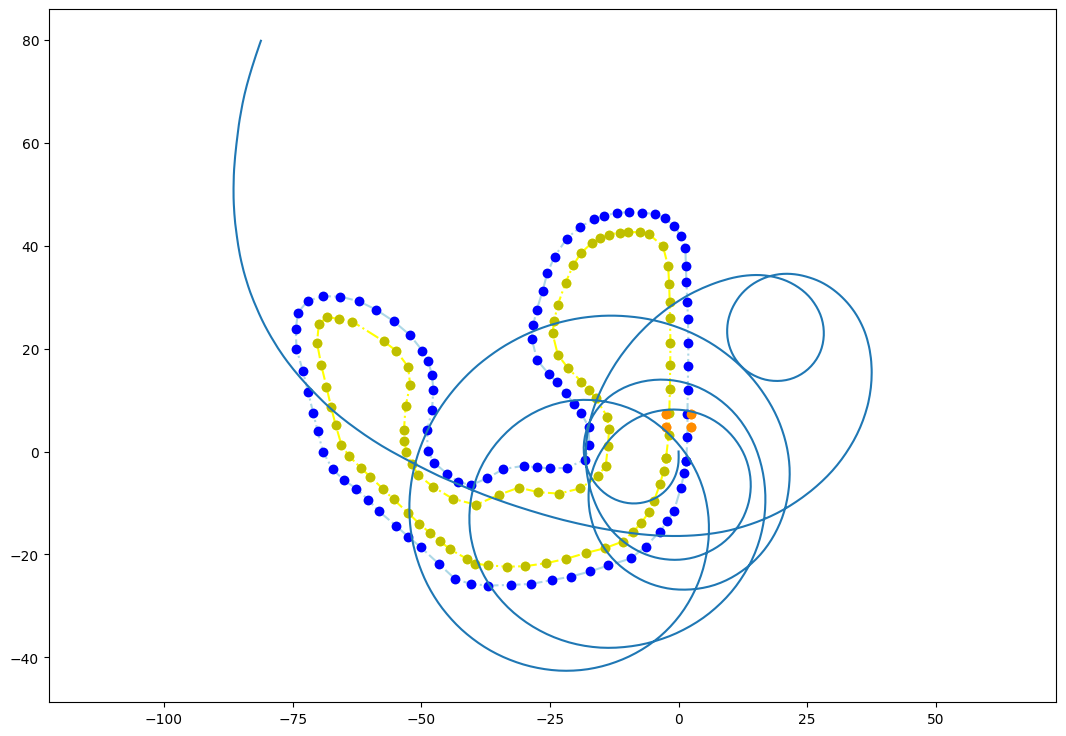

In [25]:
# simulation main
from TriangulationNew import Triangulation
from track_plotter import getTrackdrive, getSkidpad, getAccel, getAutoX
from ParametricCubicSpline import getSpline, getSplineDerivatives
from Trackdrive import cones_blue, cones_orange_big, cones_yellow

#load track + path_planning points
fig,ax = plt.subplots()
fig.set_size_inches(13,9)
track = getTrackdrive(ax, return_points=True)
track_new = np.concatenate([cones_blue,cones_yellow,cones_orange_big])
tri = Triangulation(track)
points = np.vstack((tri.midpoints, tri.midpoints[0,:]))
points_mpc = np.vstack((tri.midpoints, tri.midpoints[0,:])).T
spline_mpc = getSpline(points, axis=None, boundary_condition='closed_loop').T
path_points=spline_mpc[:,:-1]

#load MPC results
steer=np.loadtxt("mpc_steering.txt")
torques=np.loadtxt("mpc_torques.txt")
print(steer.shape,torques.shape)
camber = quantity_per_tire()
results_vx = []
results_X = []
results_Y = []
results_vy = []
results_r = []
#set initial conditions of state
index0=1950
s = state_obj()
s.X = path_points[0][index0]
s.Y = path_points[1][index0]
s.Ux = 0.1
s.yaw = -np.arctan((path_points[1][index0+1]-path_points[1][index0])/(path_points[0][index0+1]-path_points[0][index0]))
it = np.shape(steer)[0]
print("steer angle array is: ",steer)
print("torque array is: ",torques)
for i in range(it):
    inputs=input_obj()
    if(torques[i]>=0):
        inputs.Tg=torques[i]
        inputs.Tb=0.0
        inputs.steer_angle=steer[i]
    else:
        inputs.Tg=0.0
        inputs.Tb=torques[i]
        inputs.steer_angle=steer[i]
    s = runge_kutta_upd(s, inputs, 0.05)
    results_vx.append(s.Ux)
    results_vy.append(s.Uy)
    results_X.append(s.x)
    results_Y.append(s.y)
    results_r.append(s.yaw_rate)

#plot all results
cones_blue = np.flip(cones_blue[:,:2], 1)
cones_yellow = np.flip(cones_yellow[:,:2], 1)
cones_orange_big = np.flip(cones_orange_big[:,:2], 1)
#create figure
l0, = plt.plot(cones_blue[:,0], cones_blue[:,1], 'bo')
l1,  = plt.plot(cones_yellow[:,0], cones_yellow[:,1], 'yo')
l2, = plt.plot(cones_orange_big[:,0],cones_orange_big[:,1], color='None', marker='o', markerfacecolor='darkorange', markeredgecolor='None', markersize=7)
l3, = plt.plot(results_X, results_Y)
plt.axis('equal')
plt.show()